In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy

from keras.layers import Activation, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras.optimizers import SGD
from matplotlib import pyplot
from sklearn.manifold import Isomap, LocallyLinearEmbedding, MDS, SpectralEmbedding

Using TensorFlow backend.


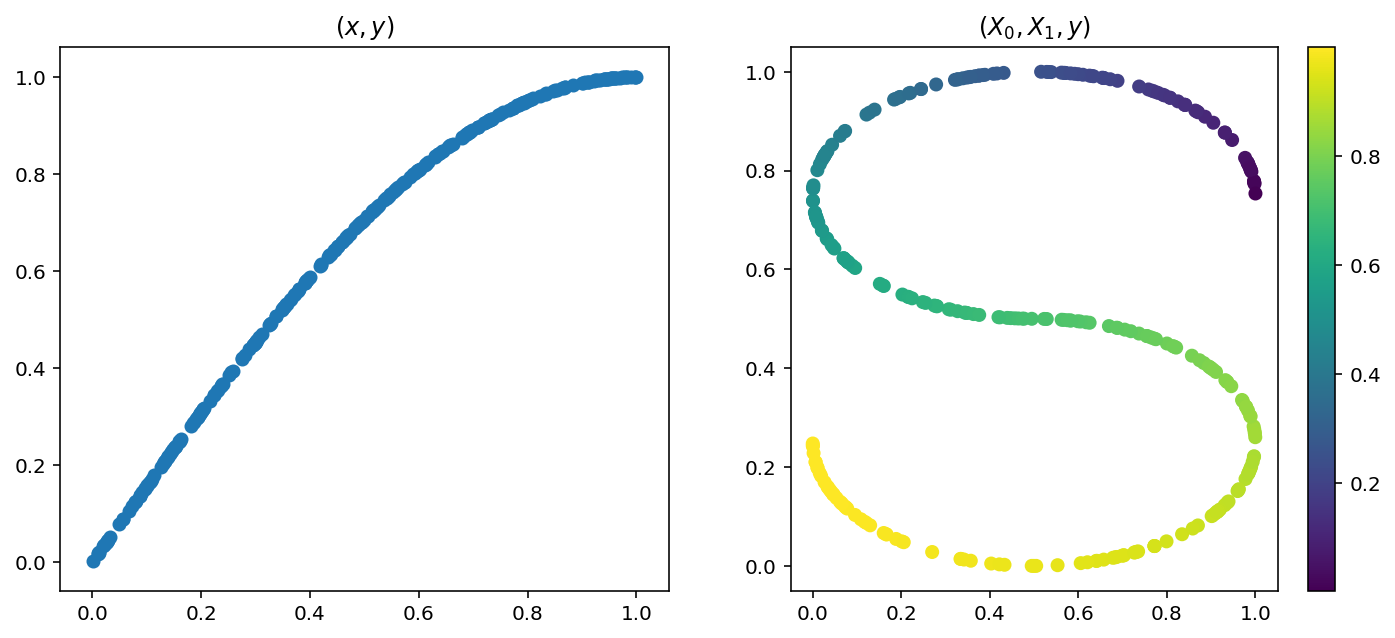

In [2]:
def get_real_data(num_samples):
    ''' Get some data in the 'true' space. In this case we have things distributed on [0, 1).
        Return (X, y).
    '''
    x = numpy.random.random(num_samples)
    y = numpy.sin(x * numpy.pi / 2)
    
    # TODO add a little noise?
    return x, y

    
def embed_features(x):
    ''' Given an input vector, apply a transformation to embed it in a higher dimensional space. '''
    assert len(x.shape) == 1, 'Unsupported shape {}'.format(x.shape)

    # TODO add noise, optionally?
    new_X = numpy.zeros((x.shape[0], 2))

    # This is the true embedding transformation - it creates an S shape in (0, 1) box
    t = 3 * numpy.pi * (x - 0.5)
    new_X[:, 0] = (1 + numpy.sin(t)) / 2
    new_X[:, 1] = (numpy.sign(t) * (numpy.cos(t) - 1) + 2) / 4

    return new_X

pyplot.figure(figsize=(12, 5))
pyplot.subplot(1, 2, 1)
num_samples = 300
x, y = get_real_data(num_samples)
pyplot.scatter(x, y);
pyplot.title('$(x, y)$')

X = embed_features(x)

pyplot.subplot(1, 2, 2)
pyplot.title('$(X_0, X_1, y)$')
pyplot.scatter(X[:, 0], X[:, 1], c=y);
pyplot.xlim(-0.05, 1.05)
pyplot.ylim(-0.05, 1.05)
pyplot.colorbar();

### Study manifold learning

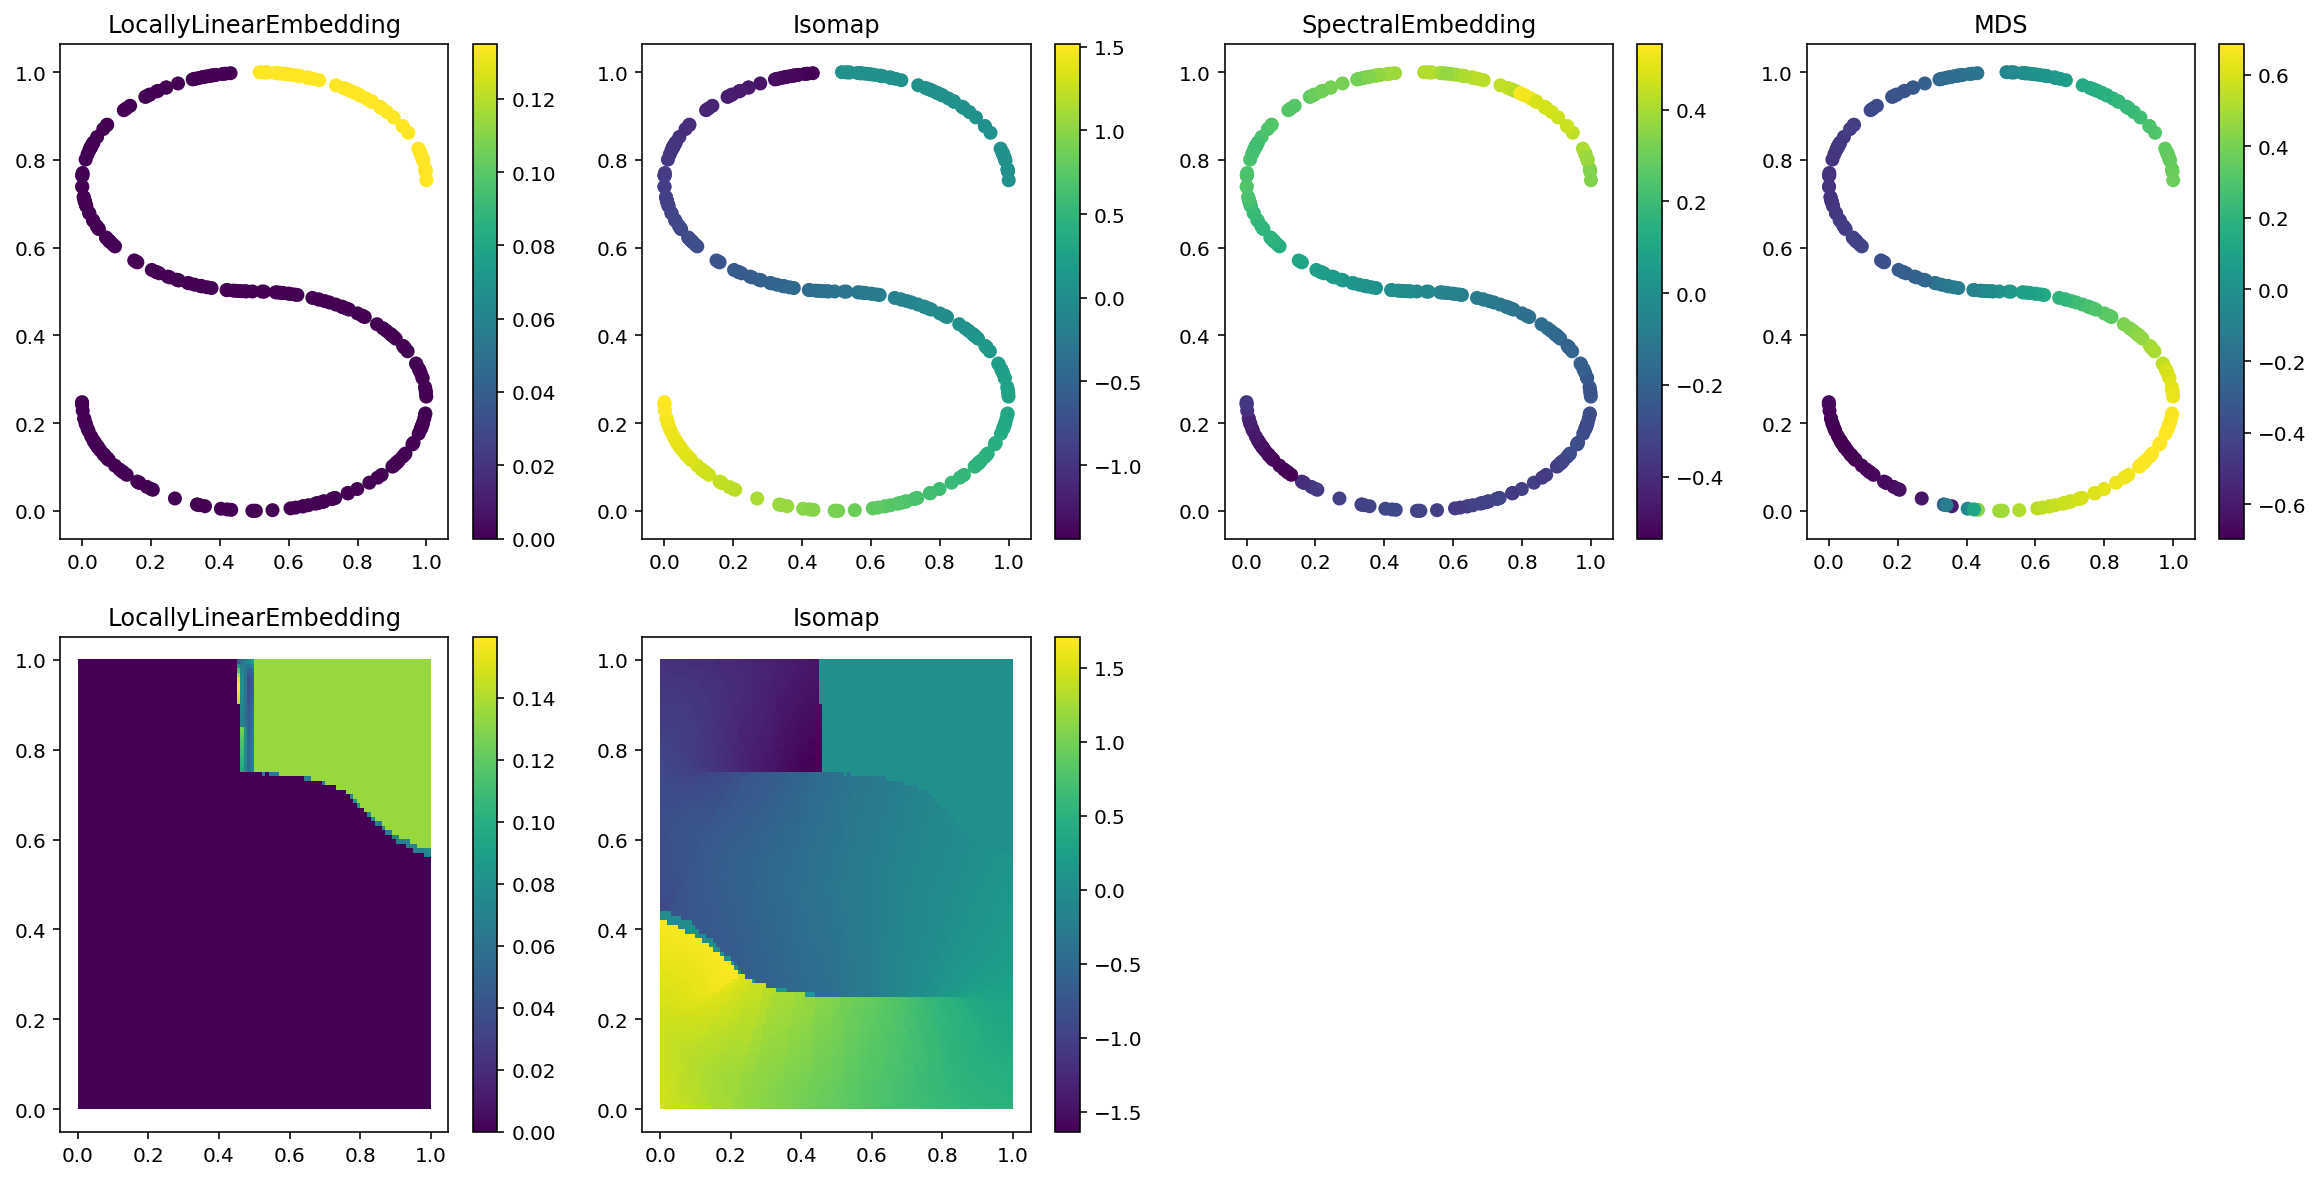

In [16]:
def _make_grid(num_grid_points):
    ''' Make a 2D grid with the given number of points in each dimension '''
    x = numpy.linspace(0, 1, num_grid_points)
    X0, X1 = numpy.asarray(numpy.meshgrid(x, x))
    return numpy.stack((X0.flatten(), X1.flatten()), axis=1)


def _plot_full_embedding(predictor, num_grid_points=100):
    ''' Given a mapping from X -> t, plot the full embedding '''
    X_full = _make_grid(num_grid_points)
    t_full = predictor(X_full)
    # The imshow command is roughly equivalent to the commented-out scatter call, however should look
    # better, and be much faster.
    # pyplot.scatter(X_full[:, 0], X_full[:, 1], c=t_full)
    pyplot.imshow(t_full.reshape((num_grid_points, num_grid_points)),
                  origin='lower',
                  extent=[0, 1, 0, 1],
                  aspect='auto')
    pyplot.colorbar();
    pyplot.xlim(-0.05, 1.05)
    pyplot.ylim(-0.05, 1.05)


models = [
#     LocallyLinearEmbedding(n_components=1, method='modified'),
    LocallyLinearEmbedding(n_components=1),
    Isomap(n_components=1),
    # These can only be used with fit_transform
    SpectralEmbedding(n_components=1),
    MDS(n_components=1),
]

pyplot.figure(figsize=(20, 10))

for i, model in enumerate(models):
    # Suitable for models which only implement fit_transform
    t = model.fit_transform(X)
    
    if hasattr(model, 'transform'):
        # In this case, the model supports transformation of any point in the 2D space onto the 1D surface.
        # Visualise to see if it makes any sense
        pyplot.subplot(2, len(models), len(models) + (i + 1))
        _plot_full_embedding(model.transform)
        pyplot.title(type(model).__name__)
    
    pyplot.subplot(2, len(models), i + 1)
    pyplot.title(type(model).__name__)
    pyplot.scatter(X[:, 0], X[:, 1], c=t)
    pyplot.colorbar();
    

## Autoencoder
Try using a neural-net based autoencoder for compressing through a hidden dimension of size 1

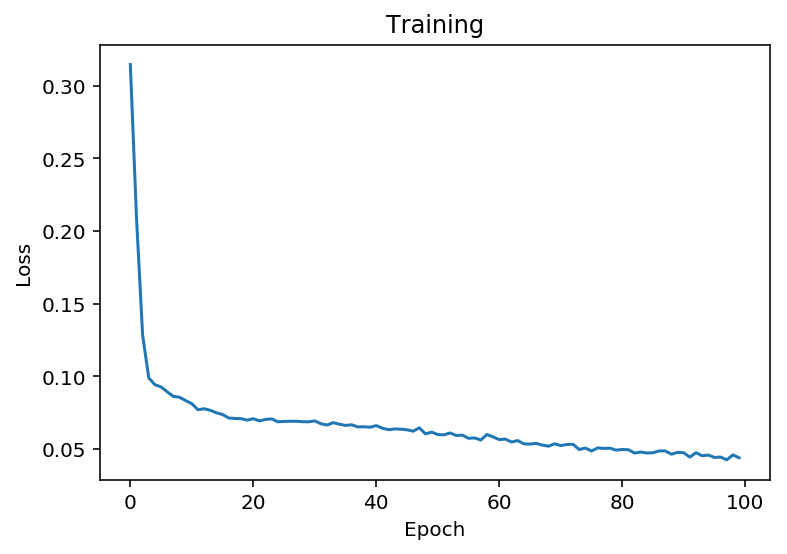

In [4]:
def train_autoencoder(X, n_layers=1, layer_size=100, epochs=100, dim_encoded=1, plot=True):
    ''' Create and train an autoencoder model. Return the encoder and decoder parts separately '''
    dim_original = X.shape[1]
    
    encoder = Sequential()
    encoder.add(InputLayer((dim_original,)))
                      
    for i in range(n_layers):
        encoder.add(Dense(layer_size))
        encoder.add(Activation('relu'))
        encoder.add(Dropout(0.2))
    encoder.add(Dense(dim_encoded))
    # Always squash such that the middle variable is between -1 and 1
    encoder.add(Activation('tanh'))
        
    decoder = Sequential()
    decoder.add(InputLayer((dim_encoded,)))
    for i in range(n_layers):
        decoder.add(Dense(layer_size))
        decoder.add(Activation('relu'))
        decoder.add(Dropout(0.2))
        
    decoder.add(Dense(dim_original))
    
    autoencoder = Sequential([encoder, decoder])
    autoencoder.compile('adam', 'mse')
    history = autoencoder.fit(X, X, verbose=0, epochs=epochs)
    
    if plot:
        pyplot.title('Training')
        pyplot.xlabel('Epoch')
        pyplot.ylabel('Loss')
        pyplot.plot(history.epoch, history.history['loss'])

    return encoder, decoder, history

encoder, decoder, history_1 = train_autoencoder(X)

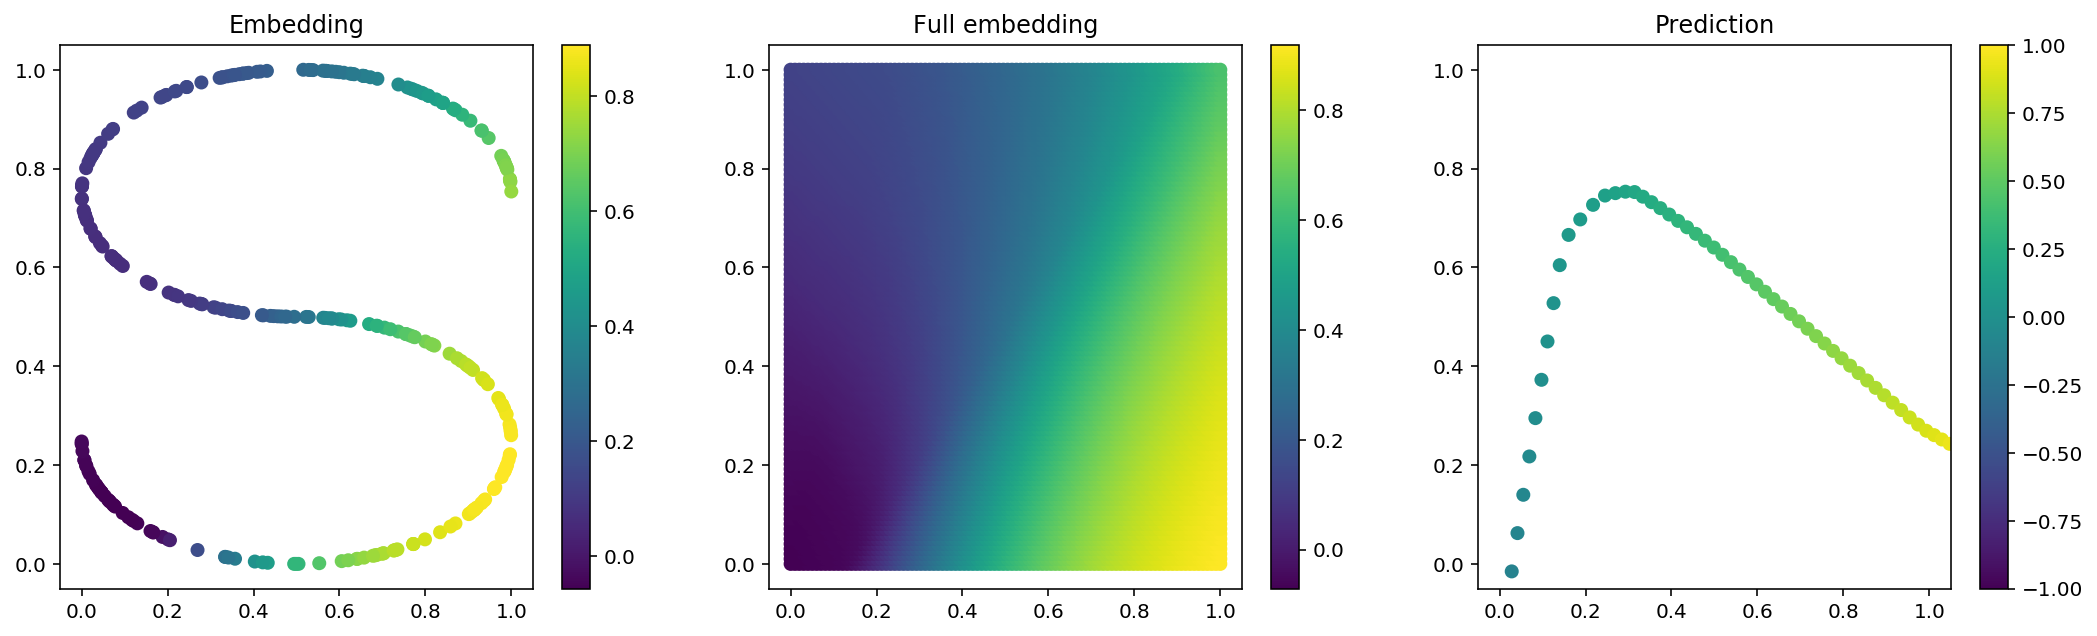

In [7]:
def _plot_decoded_points(decoder_predict, num_grid_points=100):
    ''' Creating a 1D mesh of points in the encoded variable space, see how it maps back into real space '''
    t = numpy.linspace(-1, 1, num_grid_points)
    X = decoder_predict(t)
    pyplot.scatter(X[:, 0], X[:, 1], c=t)
    pyplot.colorbar()
    pyplot.xlim(-0.05, 1.05)
    pyplot.ylim(-0.05, 1.05)


def plot_encoder_decoder(encoder, decoder):
    pyplot.figure(figsize=(18, 5))
    pyplot.subplot(1, 3, 1)
    pyplot.title('Embedding')
    pyplot.scatter(X[:, 0], X[:, 1], c=encoder.predict(X))
    pyplot.colorbar();
    pyplot.xlim(-0.05, 1.05)
    pyplot.ylim(-0.05, 1.05)


    pyplot.subplot(1, 3, 2)
    pyplot.title('Full embedding')
    _plot_full_embedding(encoder.predict)
    
    pyplot.subplot(1, 3, 3)
    pyplot.title('Prediction')
    _plot_decoded_points(decoder.predict)
    
plot_encoder_decoder(encoder, decoder)

Try autoencoders of increasing complexity

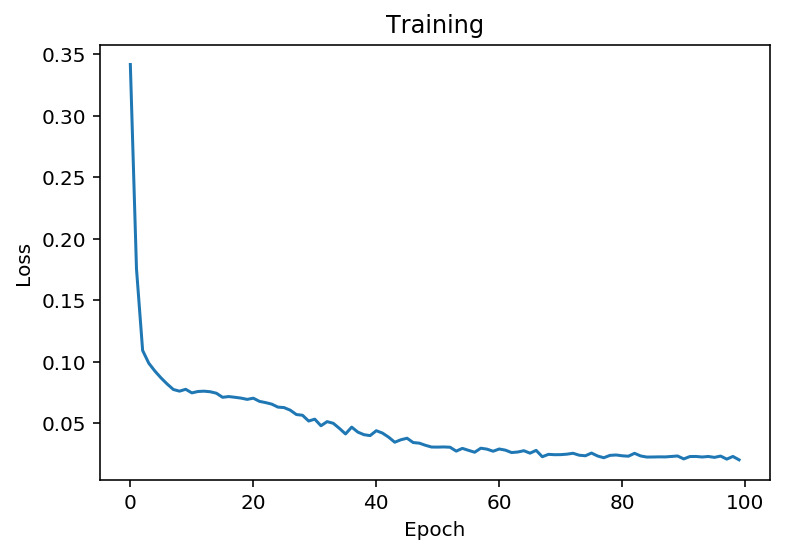

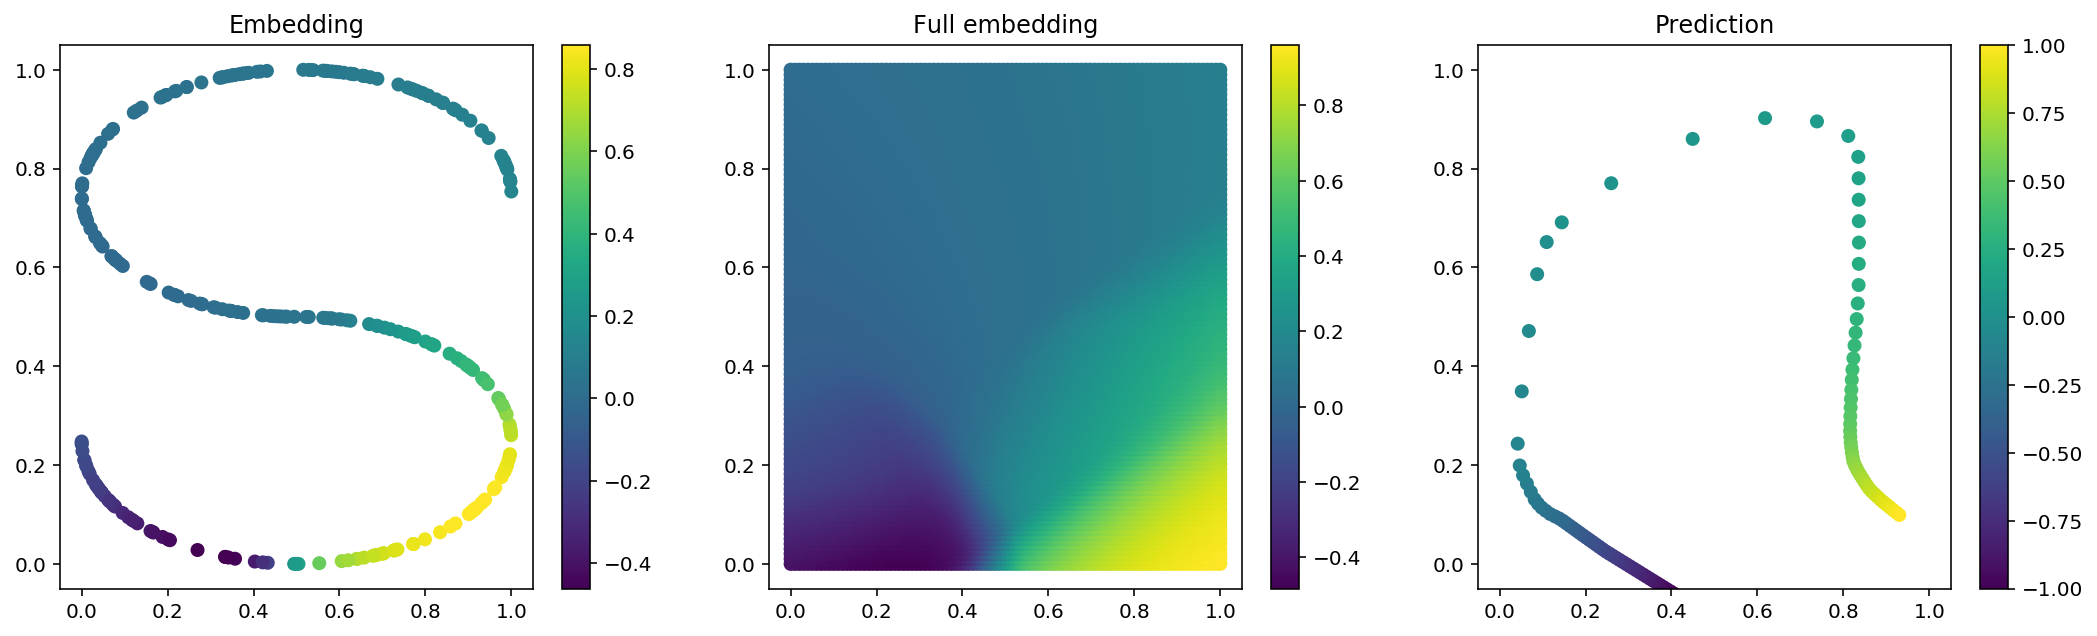

In [8]:
encoder, decoder, history_2 = train_autoencoder(X, n_layers=2)
plot_encoder_decoder(encoder, decoder)

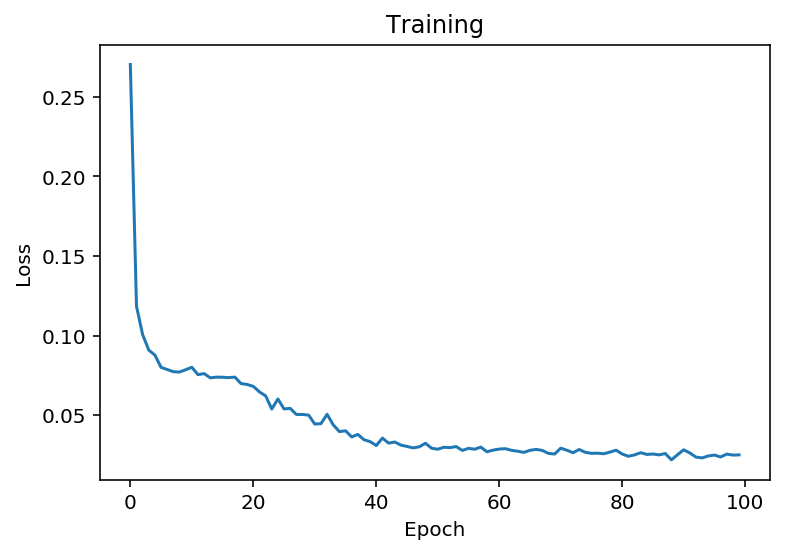

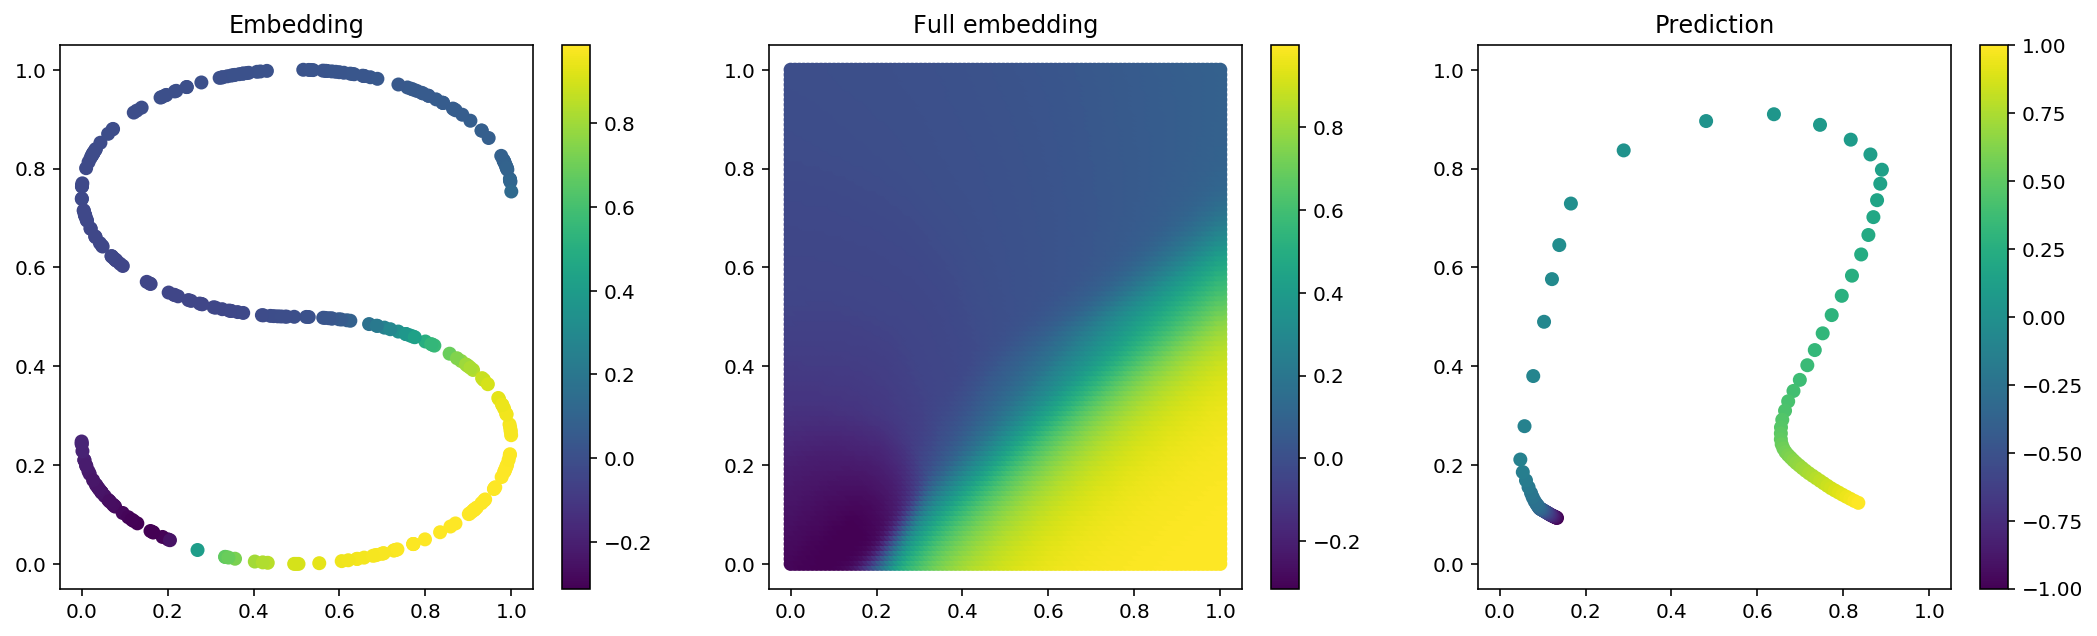

In [9]:
encoder, decoder, history_3 = train_autoencoder(X, n_layers=3)
plot_encoder_decoder(encoder, decoder)

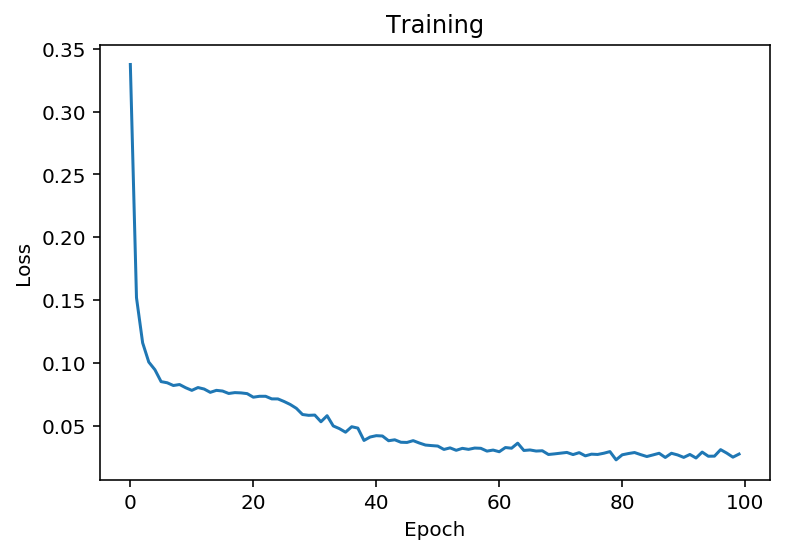

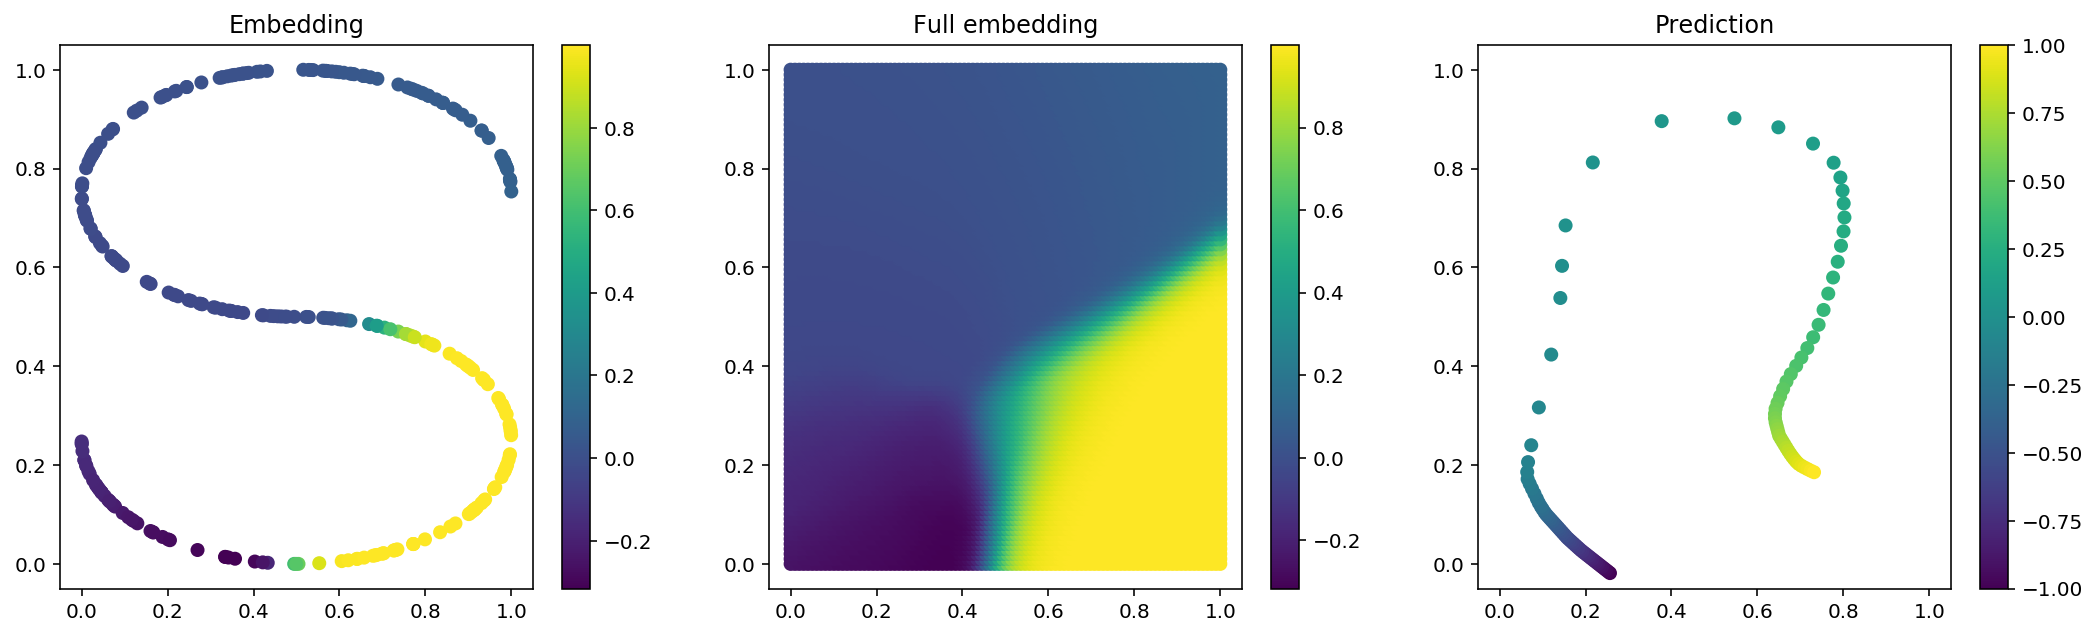

In [10]:
encoder, decoder, history_4 = train_autoencoder(X, n_layers=4)
plot_encoder_decoder(encoder, decoder)

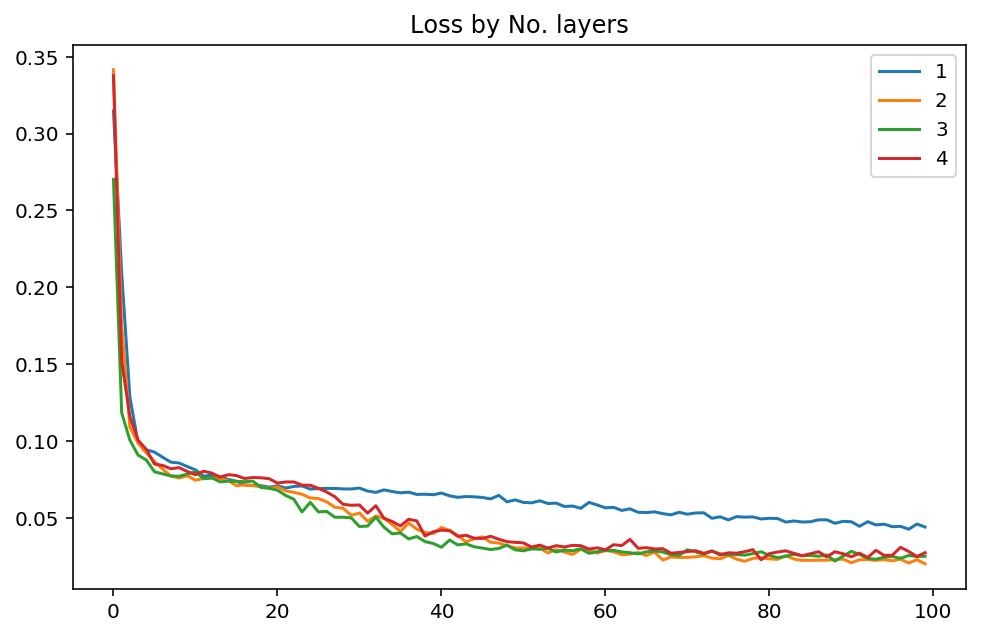

In [11]:
pyplot.figure(figsize=(8, 5))
pyplot.title('Loss by No. layers')
for n_layers, hist in enumerate((history_1, history_2, history_3, history_4), 1):
    pyplot.plot(hist.epoch, hist.history['loss'], label=n_layers)
pyplot.legend();

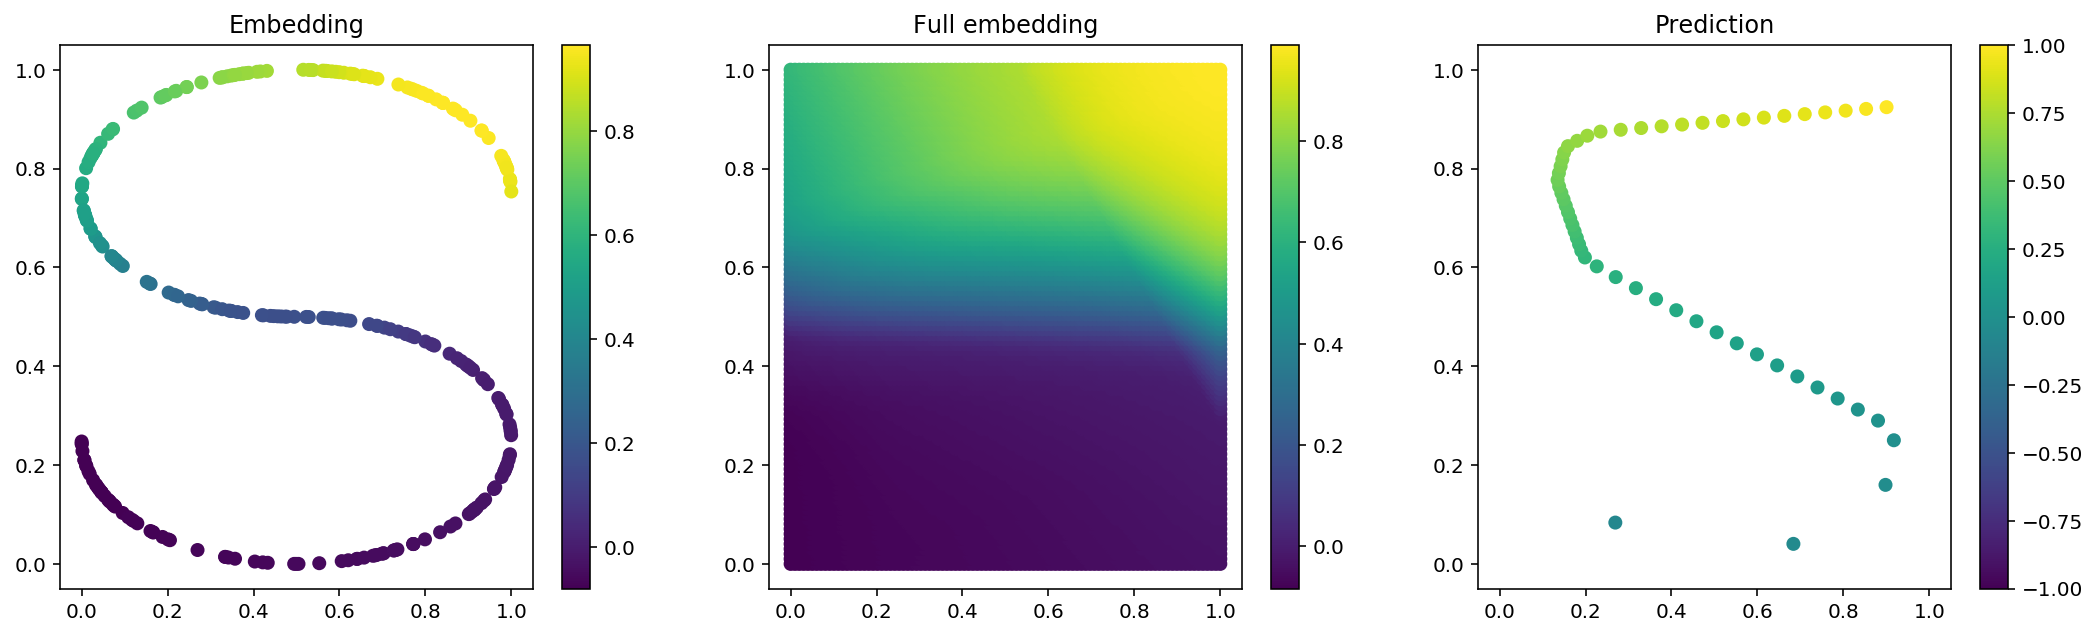

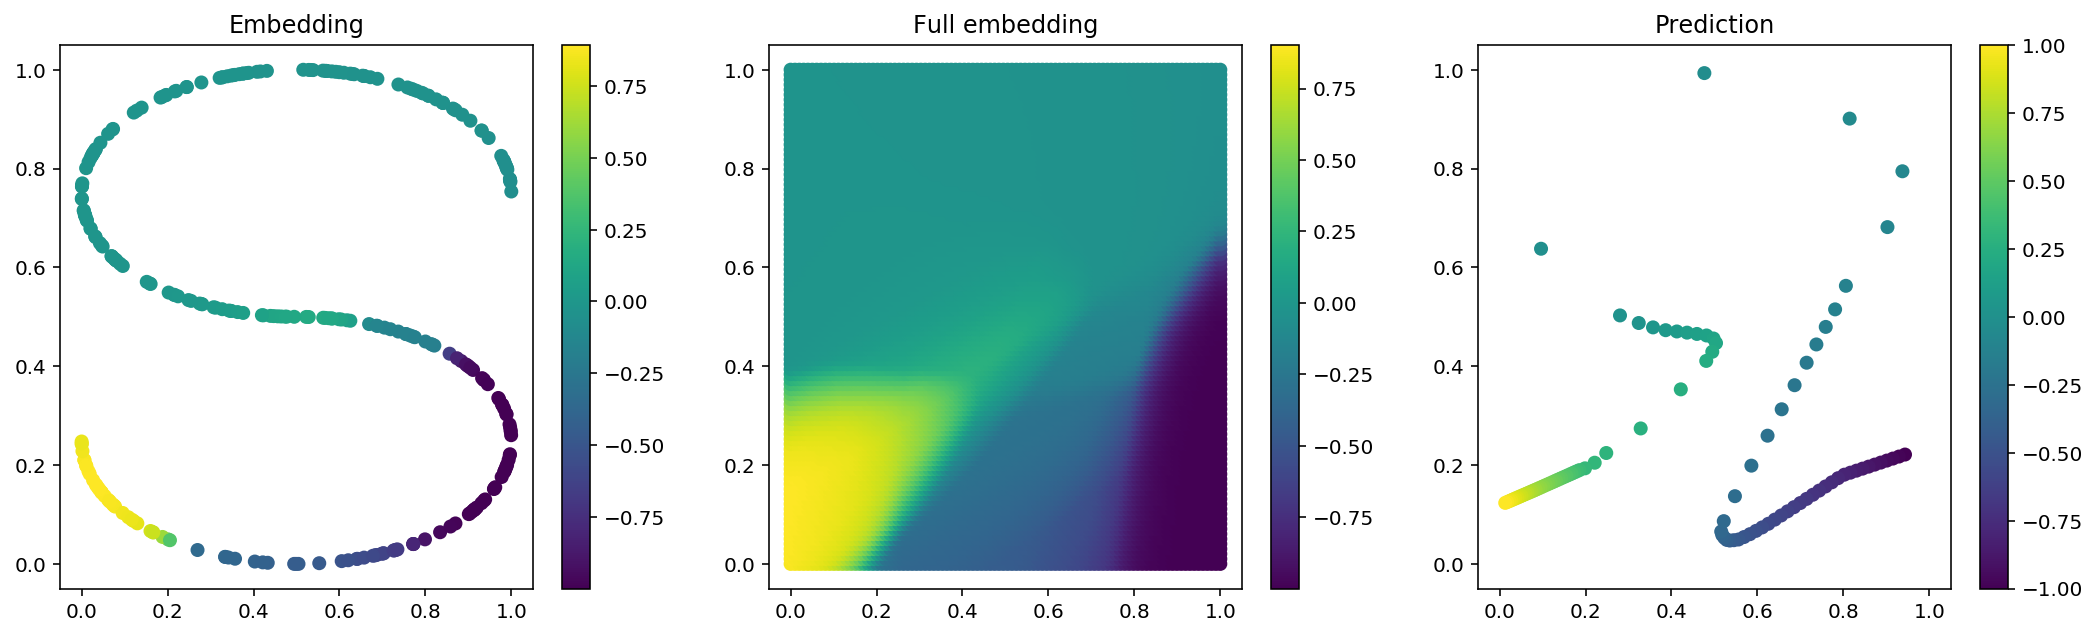

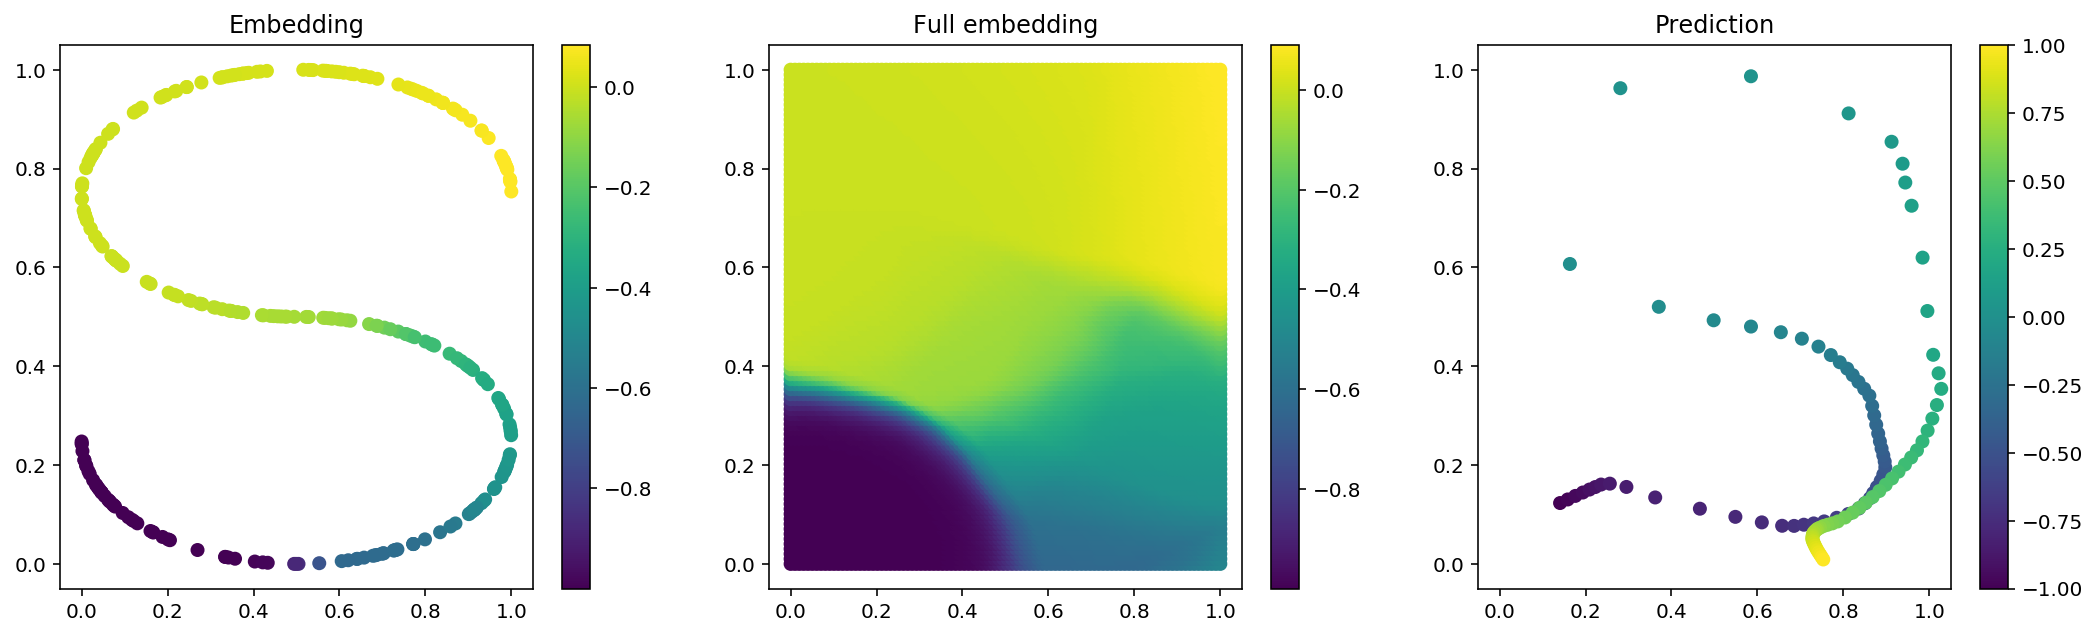

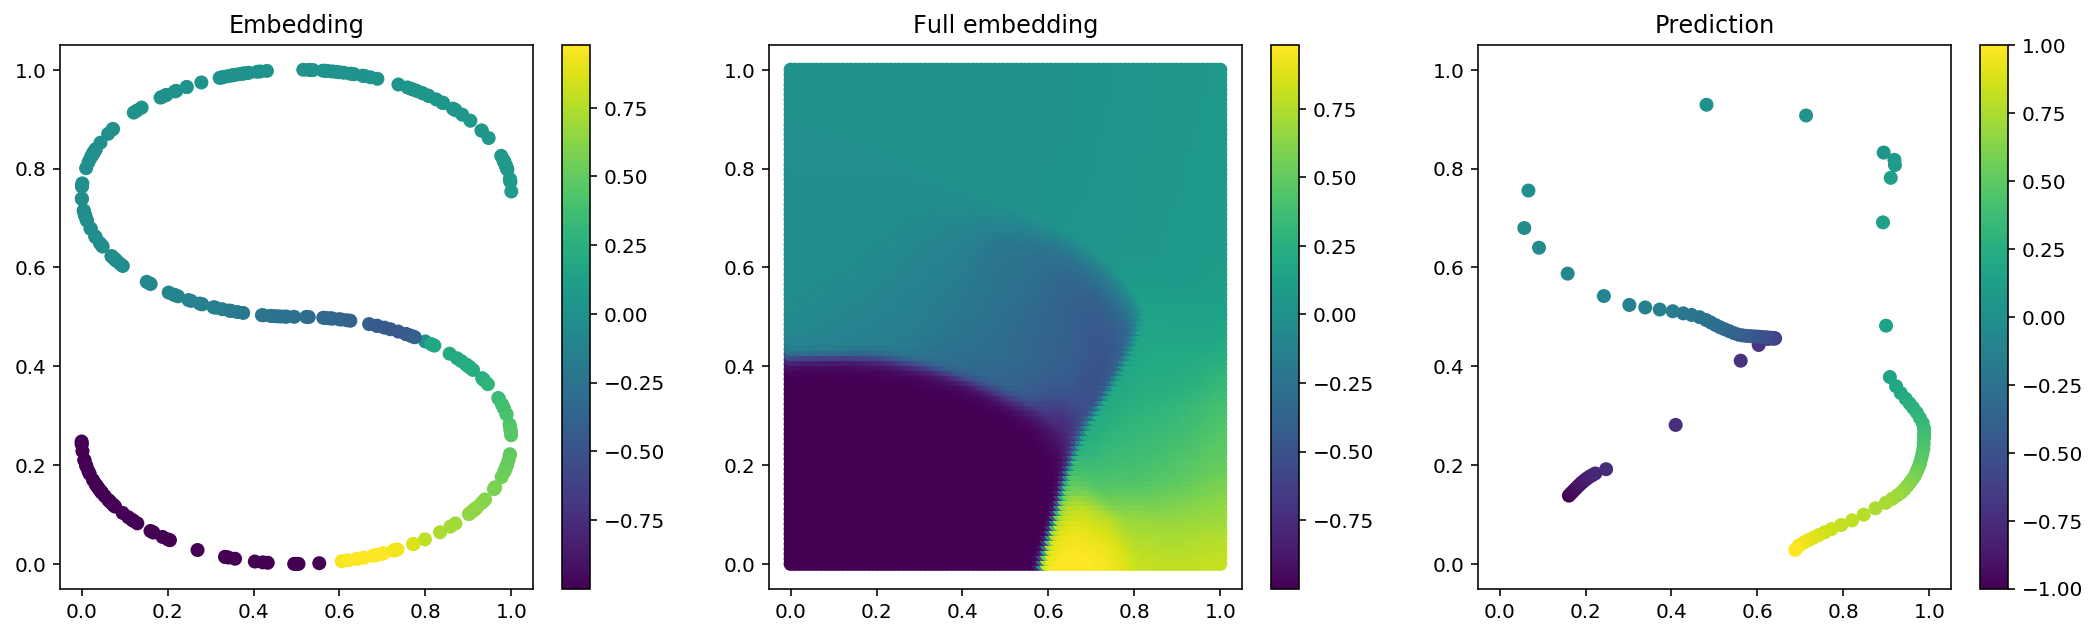

In [12]:
encoder, decoder, history_1_long = train_autoencoder(X, n_layers=1, epochs=1000, plot=False)
plot_encoder_decoder(encoder, decoder)
encoder, decoder, history_2_long = train_autoencoder(X, n_layers=2, epochs=1000, plot=False)
plot_encoder_decoder(encoder, decoder)
encoder, decoder, history_3_long = train_autoencoder(X, n_layers=3, epochs=1000, plot=False)
plot_encoder_decoder(encoder, decoder)
encoder, decoder, history_4_long = train_autoencoder(X, n_layers=4, epochs=1000, plot=False)
plot_encoder_decoder(encoder, decoder)

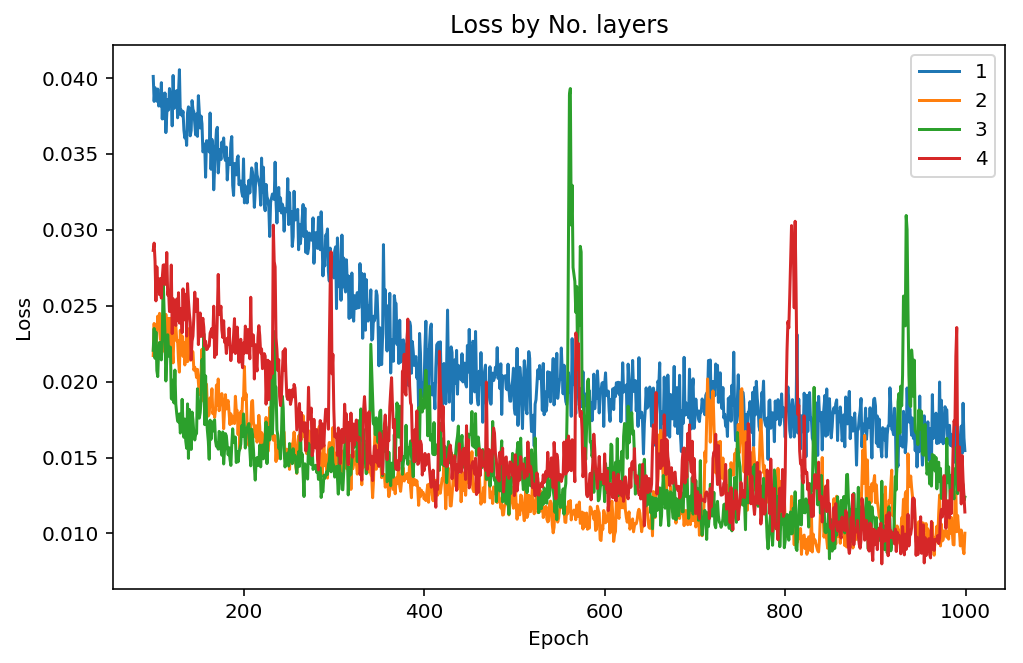

In [13]:
pyplot.figure(figsize=(8, 5))
pyplot.title('Loss by No. layers')
for n_layers, hist in enumerate((history_1_long, history_2_long, history_3_long, history_4_long), 1):
    pyplot.xlabel('Epoch')
    pyplot.ylabel('Loss')
    pyplot.plot(hist.epoch[100:], hist.history['loss'][100:], label=n_layers)
pyplot.legend();

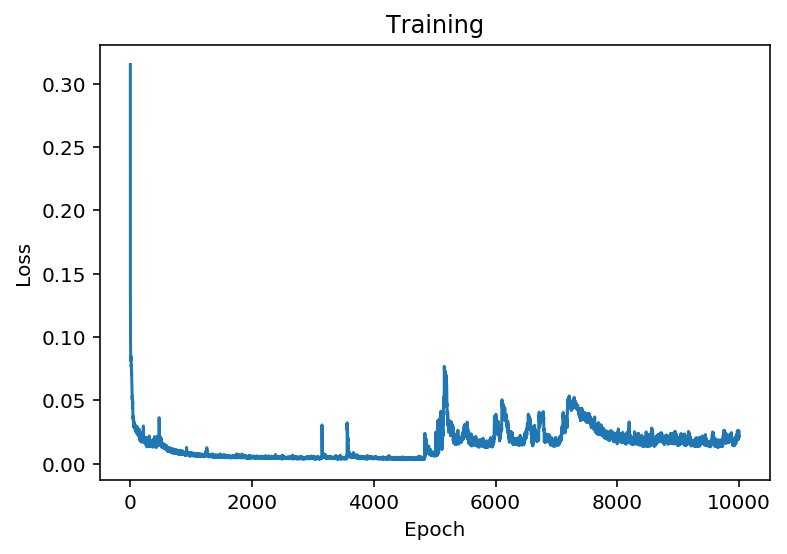

In [14]:
encoder, decoder, history_4_v_long = train_autoencoder(X, n_layers=4, epochs=10000, plot=True)

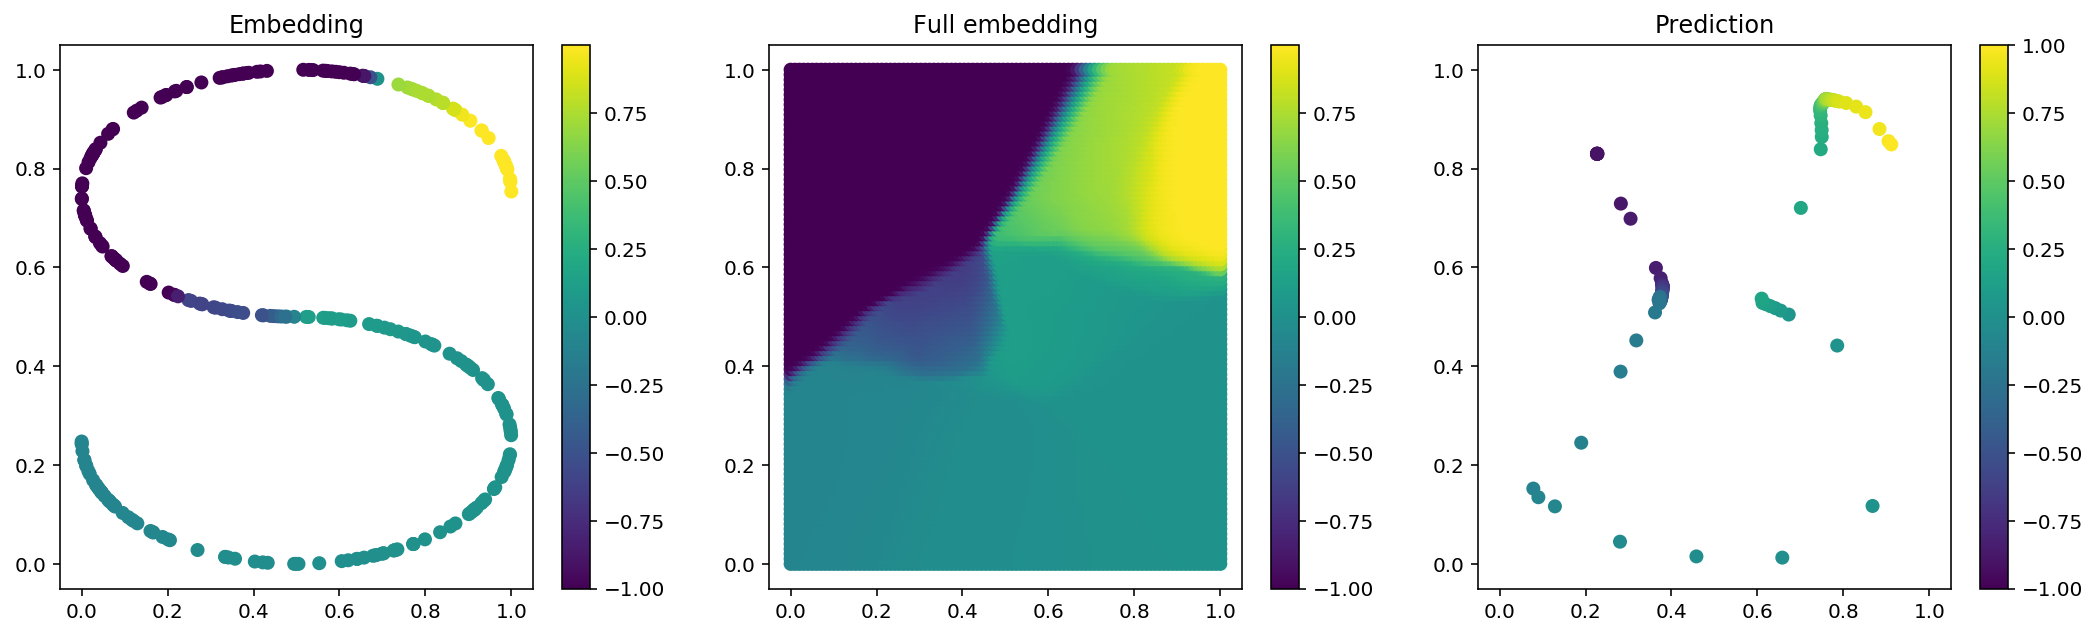

In [15]:
plot_encoder_decoder(encoder, decoder)

## Thoughts

It is possible that the poor performance seen thus far stems from the loss function. In particular:

* We are using mean-squared error (MSE) for each point (X0, X1) that we push the the autoencoder
* Thus there is a significant penalty for getting points more than a little wrong. Are we simply resigning to the fact that most of the points are fitting poorly, and focussing on improving a few points to almost exact matching?

